In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import build
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, Dropout
from tensorflow.keras import Model


2024-05-28 22:22:31.530382: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-28 22:22:31.549434: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-28 22:22:31.549453: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-28 22:22:31.549988: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-28 22:22:31.553481: I tensorflow/core/platform/cpu_feature_guar

In [2]:
df = build.load_data("output.csv")

In [3]:
#df_test = df.iloc[:100]
#df_test

In [134]:
type(df['artist_terms_weights'][0][0])

str

In [135]:
df['artist_terms'][752]

['nan']

In [139]:
def get_term_index(df):
    unique_terms = set(term for sublist in df['artist_terms'] for term in sublist)
    term_index = {term: idx for idx, term in enumerate(unique_terms)}
    return term_index

In [142]:
def create_inputdata_ws(df):
    udf = df[['hottness', 'loudness', 'tempo']]
    aadf = df[['artist_terms', 'artist_terms_weights']]
    
    # Process numerical features
    data_train_u = np.array(udf.values)

    # Process artist terms
    
    term_index = get_term_index(df)

    data_train_aa = np.zeros((len(df), len(term_index)))
    
    for i, (terms, weights) in enumerate(zip(df['artist_terms'], df['artist_terms_weights'])):
        if 'nan' not in terms:
            for term, weight in zip(terms, weights):
                    weight_float = float(weight)
                    idx = term_index[term]
                    data_train_aa[i, idx] = weight_float
            
    data_train = np.concatenate((data_train_u, data_train_aa), axis=1)

    return data_train

In [146]:
data_train = create_inputdata_ws(df)
#data_train[752]

In [147]:
#Check if there is nan in data
a = [i for i in range(data_train.shape[0]) if True in np.isnan(data_train[i])]
np.set_printoptions(threshold=np.inf)
a

[]

In [148]:
nan_indices = []
for index, row in df.iterrows():
    if "NaN" in row['artist_terms_weights']:
        nan_indices.append(index)

nan_indices

[]

In [149]:
def creating_autoencoder(input_size, code_size, node_size):

    # Encoder
    encoder_input = Input((input_size,))
    encoder_nl = Dense(node_size, activation='relu')(encoder_input)
    encoder_encode = Dense(code_size, activation='relu')(encoder_nl)

    # Decoder
    decoder_nl = Dense(node_size, activation='relu')(encoder_encode)
    decoder_output = Dense(input_size)(decoder_nl)

    # Build the autoencoder model
    autoencoder = Model(encoder_input, decoder_output)
    autoencoder.compile(loss='MSE', optimizer=tf.optimizers.Adam(learning_rate=0.001))

    # Build the encoder model
    encoder = Model(encoder_input, encoder_encode)

    
    return autoencoder, encoder

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0074
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0044
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0035
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0032
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0029
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0027
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0026
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0025
Epoch 9/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0024
Epoch 10/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0024


Text(0, 0.5, 'loss')

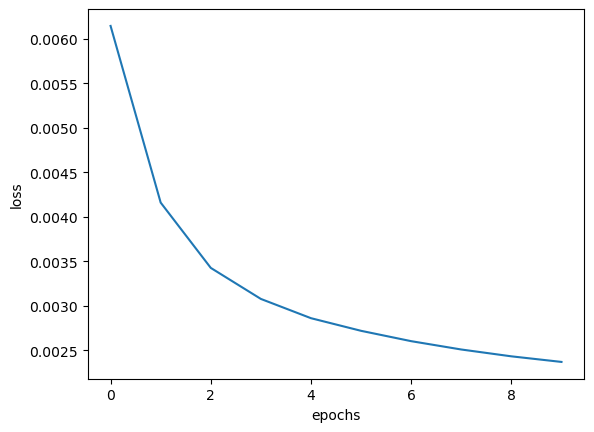

In [150]:
autoencoder, encoder = creating_autoencoder(data_train.shape[1],128, 200)
ae_history = autoencoder.fit(data_train, data_train, epochs=10)

plt.plot(ae_history.history['loss']);
plt.xlabel('epochs')
plt.ylabel('loss')

In [151]:
m = []
for j in np.random.randint(0, 10000, size=1000):
    pred = autoencoder.predict(np.array([data_train[j]]))
    #m.append(max([ pred[0][i] - data_train[j][i] for i in range(1075)]))
    m.append(np.linalg.norm(pred[0] - data_train[j]))
    

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


3.3837293275426683

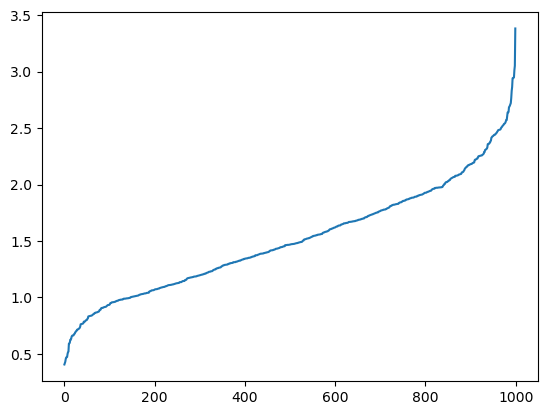

In [153]:
m.sort()
plt.plot(np.array(m))
max(m)

In [154]:
type(encoder.predict(np.array([data_train[0]]))[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


numpy.ndarray

In [156]:
term_index = get_term_index(df)

In [168]:
def distance_encoder(song1, song2, encoder, term_index):
    """
    songs must be of the form ['artist_name', 'title', 'release', 'similar', 'hottness', 'artist_terms', 'artist_terms_weights', 'loudness', 'tempo']
    
    term_index has to be done on the full dataset 
    """
    
    hsong1, hsong2 = np.array([song1[4], song1[7], song1[8]]), np.array([song2[4], song2[7], song2[8]])

    atw1, atw2 = np.zeros(len(term_index)), np.zeros(len(term_index))
    
    if not any(pd.isna(song1[5])):  # Assuming song1[5] and song1[6] are lists of terms and weights
        for term, weight in zip(song1[5], song1[6]):
            weight_float = float(weight)
            idx = term_index[term]
            atw1[idx] = weight_float

    if not any(pd.isna(song2[5])):  # Assuming song2[5] and song2[6] are lists of terms and weights
        for term, weight in zip(song2[5], song2[6]):
            weight_float = float(weight)
            idx = term_index[term]
            atw2[idx] = weight_float
        
    hsong1 = np.concatenate([hsong1, atw1])
    hsong2 = np.concatenate([hsong2, atw2]) 
    
    encoded_song1, encoded_song2 = encoder.predict(np.array([hsong1, hsong2]))
    
    return np.linalg.norm(encoded_song1-encoded_song2)
    

In [176]:
song1, song2, song3 = df.iloc[0].values, df.iloc[1].values, df.iloc[2].values

In [180]:
distance_encoder(song3, song2, encoder, term_index)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


2.410677